# Credits

This notebook is partially based on this https://github.com/pedropro/TACO/blob/master/demo.ipynb and 
https://github.com/pedropro/TACO/blob/master/detector/detector.ipynb and
https://www.kaggle.com/kneroma/clean-planet-trash-detection-dataset from the original **taco** project and kaggle.

Updated to detectwaste by:
* Agnieszka Mikołajczyk
* Katarzyna Łangowska
* Maria Ferlin


#  EDA 
## TACO and detect-waste

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 shows the class hierarchical structure: super classes and classes
- Section 3 shows TACO images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [1]:
%matplotlib inline
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

from collections import Counter

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)


dataset_path = '/dih4/dih4_2/wimlds/TACO-master/data'
anns_file_path = dataset_path + '/' + 'annotations.json'
epinote_dataset_path = '/dih4/dih4_2/wimlds/data/not-annotated'
epinote_anns_file_path = '/dih4/dih4_2/wimlds/data/annotations_epi.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
with open(epinote_anns_file_path, 'r') as f:
    epinote_dataset = json.loads(f.read())

In [2]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [3]:
categories

[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'},
 {'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'},
 {'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'},
 {'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'},
 {'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'Can', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'Can', 'id': 12, 'name': 'Drink can'},
 {'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'},
 {'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'

## Annotations in COCO format
bbox = (x, y, width, height)
area = multi_poly.area

In [4]:
anns_to_print = anns[0].pop('segmentation', None) # removing segmentation polygon for better clarity
anns[0]

{'id': 1,
 'image_id': 0,
 'category_id': 6,
 'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'iscrowd': 0}

## 1.  Dataset statistics
### TACO categories

This shows the number of annotations per category:

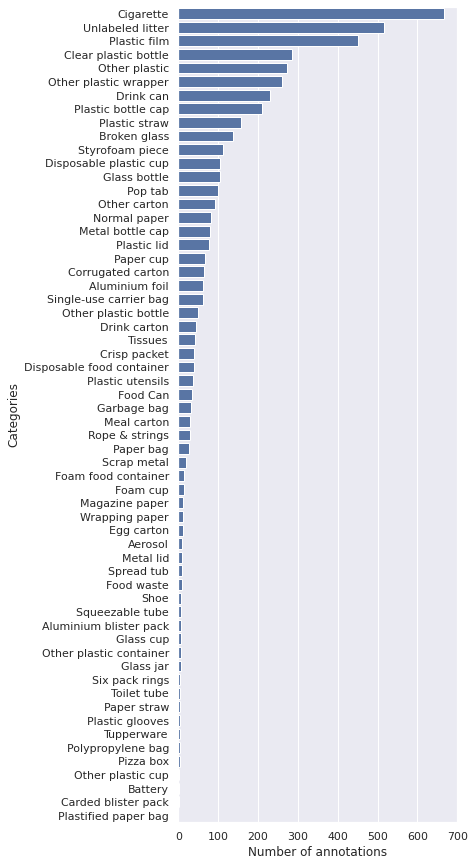

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

# fig = plot_1.get_figure()
# fig.savefig("output.png")

and this shows the number of annotations per super category:

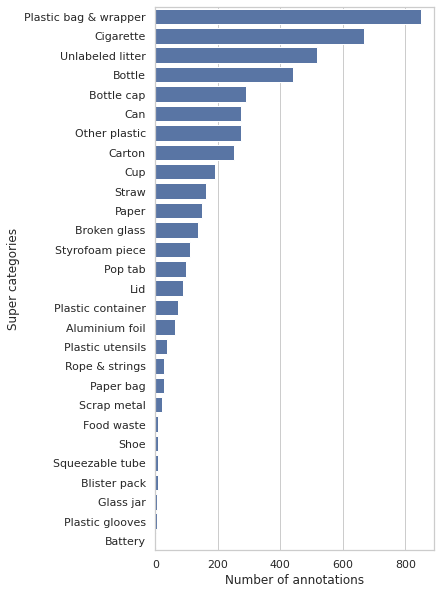

In [6]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")
#plot_1.set_title('Annotations per super category',fontsize=20)   

## detect-waste categories

This shows the number of annotations per category:

In [7]:
# convert taco label to detect-waste labels
# based on polish recykling standards
# by Katrzyna łagocka


def taco_to_detectwaste(label):
    glass = ['Glass bottle','Broken glass','Glass jar']
    metals_and_plastics = ['Aluminium foil', "Clear plastic bottle","Other plastic bottle",
                         "Plastic bottle cap","Metal bottle cap","Aerosol","Drink can",
                         "Food can","Drink carton","Disposable plastic cup","Other plastic cup",
                         "Plastic lid","Metal lid","Single-use carrier bag","Polypropylene bag",
                         "Plastic Film","Six pack rings","Spread tub","Tupperware",
                         "Disposable food container","Other plastic container",
                         "Plastic glooves","Plastic utensils","Pop tab","Scrap metal",
                         "Plastic straw","Other plastic", "Plastic film", "Food Can"]
    
    non_recyclable = ["Aluminium blister pack","Carded blister pack",
                    "Meal carton","Pizza box","Cigarette","Paper cup",
                    "Meal carton","Foam cup","Glass cup","Wrapping paper",
                    "Magazine paper","Garbage bag","Plastified paper bag",
                    "Crisp packet","Other plastic wrapper","Foam food container",
                    "Rope","Shoe","Squeezable tube","Paper straw","Styrofoam piece", "Rope & strings", "Tissues"]
    
    other = ["Battery"]
    paper = ["Corrugated carton","Egg carton","Toilet tube","Other carton", "Normal paper", "Paper bag"]
    bio = ["Food waste"]
    unknown = ["Unlabeled litter"]

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-taco label")
        label = "unknown"
    return label

In [8]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:
    cat_id = ann['category_id']
    cat_taco = categories[cat_id]['name']
    detectwaste_categories[cat_id]['supercategory'] = taco_to_detectwaste(cat_taco)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories[35]['supercategory'] = taco_to_detectwaste("Plastified paper bag")
detectwaste_categories

[{'supercategory': 'metals_and_plastics', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'other', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'non-recyclable',
  'id': 2,
  'name': 'Aluminium blister pack'},
 {'supercategory': 'non-recyclable', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'metals_and_plastics',
  'id': 4,
  'name': 'Other plastic bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 5,
  'name': 'Clear plastic bottle'},
 {'supercategory': 'glass', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 7,
  'name': 'Plastic bottle cap'},
 {'supercategory': 'metals_and_plastics', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'metals_and_plastics', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'metals_and_plastics', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'metals_and_plastics', 'id': 12, 'name': 'Drink can'},
 {'supercategory'

In [9]:
epi_categories = epinote_dataset['categories']
epi_anns = epinote_dataset['annotations']
epi_imgs = epinote_dataset['images']

def epi_to_detectwaste(epi_id):
    new_id = 6

    if epi_id == 5:
        new_id = 0
    if epi_id == 6:
        new_id = 1
    if epi_id == 3:
        new_id = 2
    if epi_id == 2:
        new_id = 3
    if epi_id == 1:
        new_id = 4
    if epi_id == 7:
        new_id = 5
    if epi_id == 4:
        new_id = 6

    return new_id


In [12]:
for cat in epi_categories:
    new_id = epi_to_detectwaste(cat['id'])
    cat['id'] = new_id
for ann in epi_anns:
    new_cat = epi_to_detectwaste(ann['category_id'])
    ann['category_id'] = new_cat
epi_categories

[{'id': 4, 'name': 'paper', 'supercategory': ''},
 {'id': 3, 'name': 'glass', 'supercategory': ''},
 {'id': 2, 'name': 'non_recyclable', 'supercategory': ''},
 {'id': 6, 'name': 'unknown', 'supercategory': ''},
 {'id': 0, 'name': 'metals_and_plastic', 'supercategory': ''},
 {'id': 1, 'name': 'other', 'supercategory': ''},
 {'id': 5, 'name': 'bio', 'supercategory': ''}]

### generate new ids for ploting histograms

In [14]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        
print(detectwaste_ids)
print(detectwaste_cat_names)

taco_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
#     if cat['id'] not in taco_to_detectwaste_ids:
#         taco_to_detectwaste_ids[cat['id']] = 0
    taco_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)

colors_recykling = ['yellow', 'gray', 'gray', 'green', 'blue', 'brown', 'pink']

anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = taco_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


{'metals_and_plastics': 0, 'other': 1, 'non-recyclable': 2, 'glass': 3, 'paper': 4, 'bio': 5, 'unknown': 6}
['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown']


Text(0.5, 1.0, 'Annotations per detectwaste category')

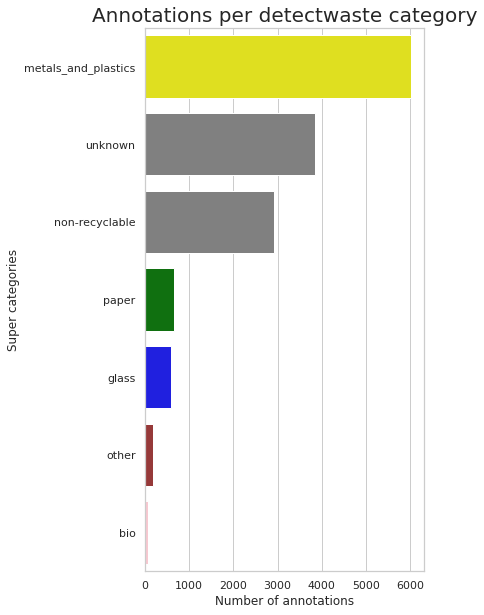

In [15]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1
    
for ann in epi_anns:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)


sns.set_palette(sns.color_palette(colors_recykling))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)   

### 2  Background stats

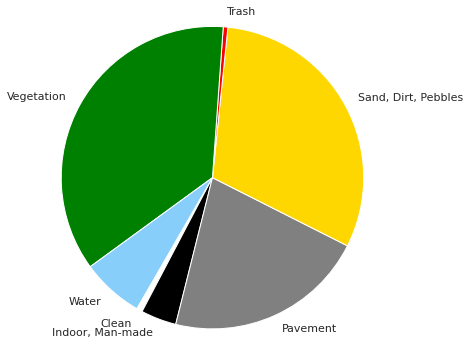

In [16]:
# Get scene cat names
scene_cats = dataset['scene_categories']
scene_name = []
pylab.rcParams['figure.figsize'] = (6,6)

for scene_cat in scene_cats:
    scene_name.append(scene_cat['name'])

nr_scenes = len(scene_cats)
scene_cat_histogram = np.zeros(nr_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:    
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_cats):
            scene_cat_histogram[scene_ann_id]+=1

# Plot
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_cat_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)
 
plt.axis('equal')
plt.show()

## 2. Visualize Annotated Images

For simplicity, to select and show the dataset images with the respective masks, we make use of the COCO API.
The script below shows how to load and visualize an image with all its annotations.

Unfortunately, several python libraries do not take into account the EXIF orientation tag, thus we have to explicitly rotate the images. Alternatively you can use instead OpenCV.

The script below shows how to filter images by either category or supercategory.

Go ahead and try different (super)categories searches by changing the `category_name`.
Note that small objects may be hard to see.

In [17]:
def extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling):
    color_id = taco_to_detectwaste_ids[ann['category_id']]
    color = colors_recykling[color_id]
    return color

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
batch_11/000028.jpg


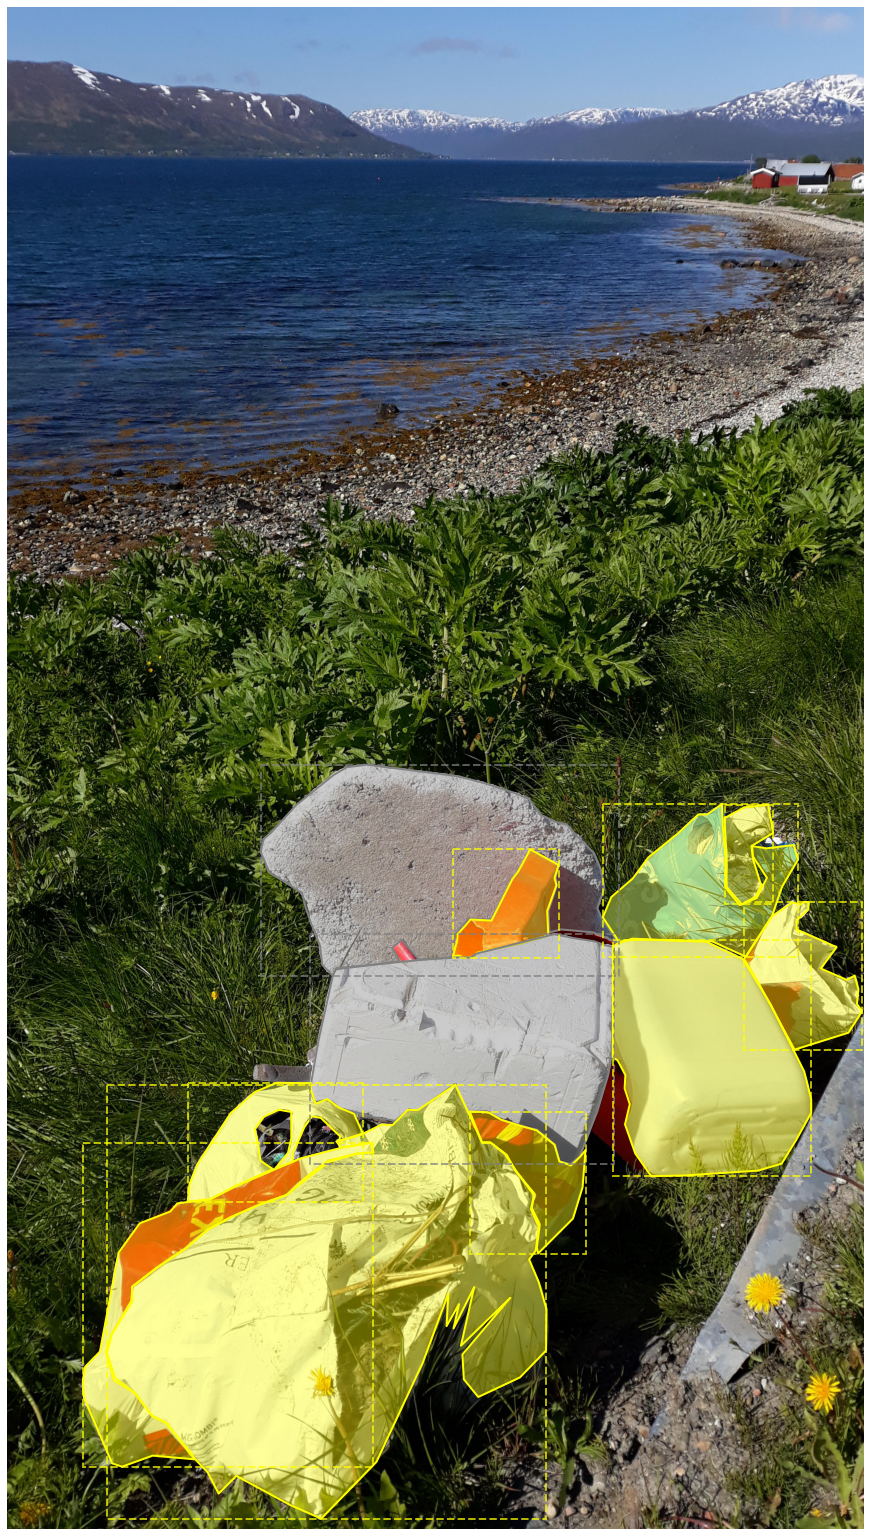

In [18]:
# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################
imgs = dataset['images']

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    I = Image.open(dataset_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of images found:  322


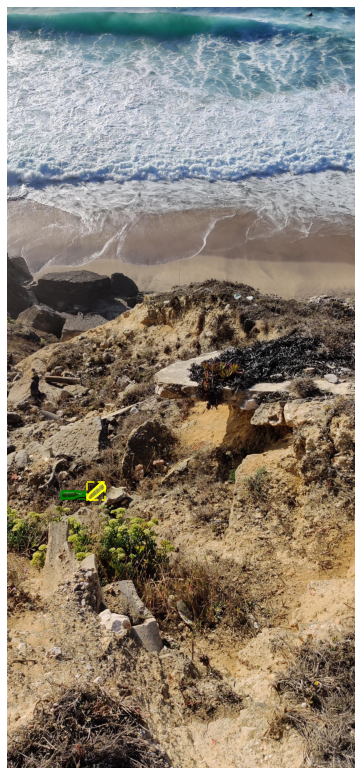

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Number of images found:  6


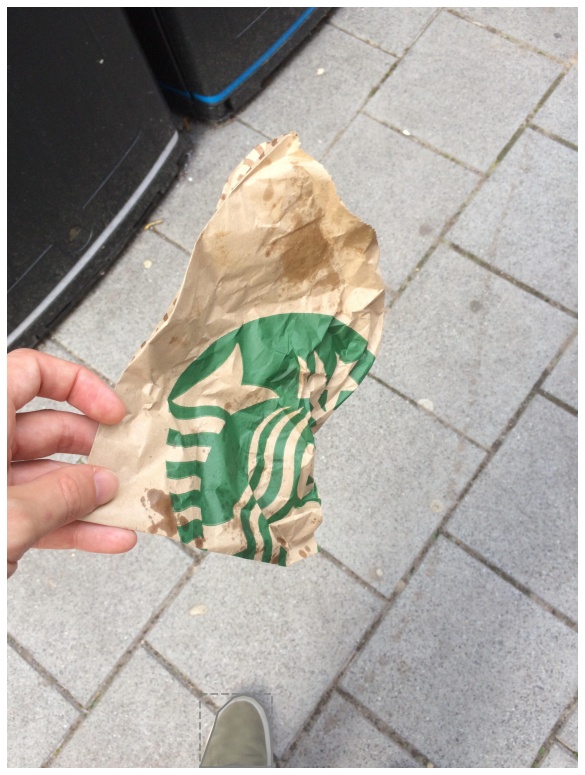

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of images found:  7


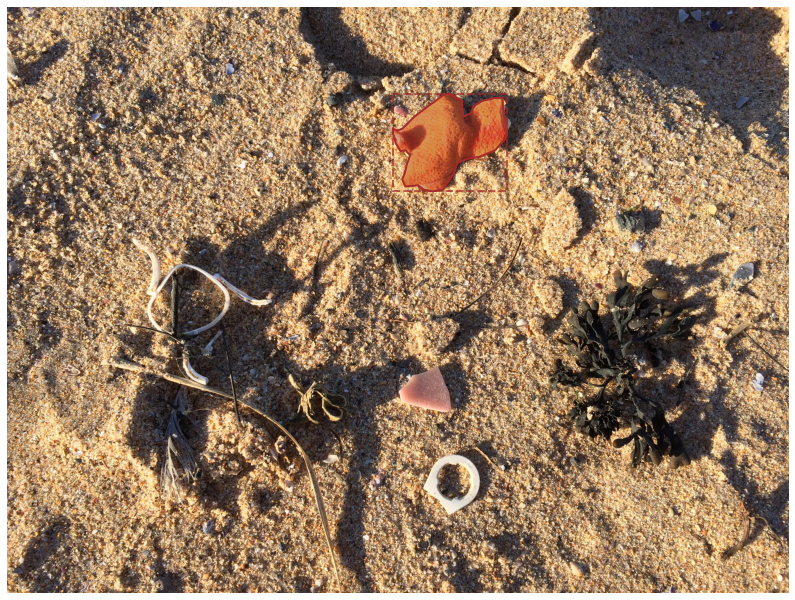

In [19]:
categories_to_show = ['Bottle', 'Shoe', 'Food waste']
nr_img_2_display = 1
pylab.rcParams['figure.figsize'] = (14,14)

for category_name in categories_to_show: #  --- Insert the name of one of the categories or super-categories above

    # Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    # Loads dataset as a coco object
    coco = COCO(anns_file_path)

    # Get image ids
    imgIds = []
    catIds = coco.getCatIds(catNms=[category_name])
    if catIds:
        # Get all images containing an instance of the chosen category
        imgIds = coco.getImgIds(catIds=catIds)
    else:
        # Get all images containing an instance of the chosen super category
        catIds = coco.getCatIds(supNms=[category_name])
        for catId in catIds:
            imgIds += (coco.getImgIds(catIds=catId))
        imgIds = list(set(imgIds))

    nr_images_found = len(imgIds) 
    print('Number of images found: ',nr_images_found)

    # Select N random images
    random.shuffle(imgIds)
    imgs = coco.loadImgs(imgIds[0:min(nr_img_2_display,nr_images_found)])

    for img in imgs:
        image_path = dataset_path + '/' + img['file_name']
        # Load image
        I = Image.open(image_path)

        # Load and process image metadata
        if I._getexif():
            exif = dict(I._getexif().items())
            # Rotate portrait and upside down images if necessary
            if orientation in exif:
                if exif[orientation] == 3:
                    I = I.rotate(180,expand=True)
                if exif[orientation] == 6:
                    I = I.rotate(270,expand=True)
                if exif[orientation] == 8:
                    I = I.rotate(90,expand=True)

        # Show image
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(I)

        # Load mask ids
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns_sel = coco.loadAnns(annIds)

        # Show annotations
        for ann in anns_sel:
            color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
            for seg in ann['segmentation']:
                poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
                p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
                ax.add_collection(p)
                p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
                ax.add_collection(p)
            [x, y, w, h] = ann['bbox']
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                             facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)

        plt.show()


## 3. bbox statistics
* average bbox size per category
* average area size per category
* average number of bbox per image

In [20]:
anns_detectwaste[1]

{'id': 2,
 'image_id': 1,
 'category_id': 2,
 'area': 1071259.5,
 'bbox': [1.0, 457.0, 1429.0, 1519.0],
 'iscrowd': 0}

In [21]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

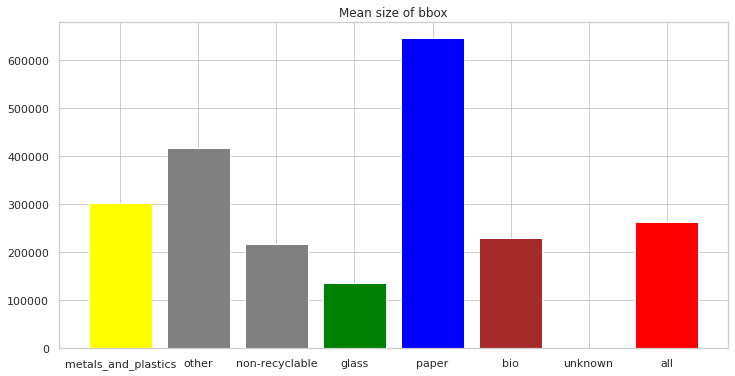

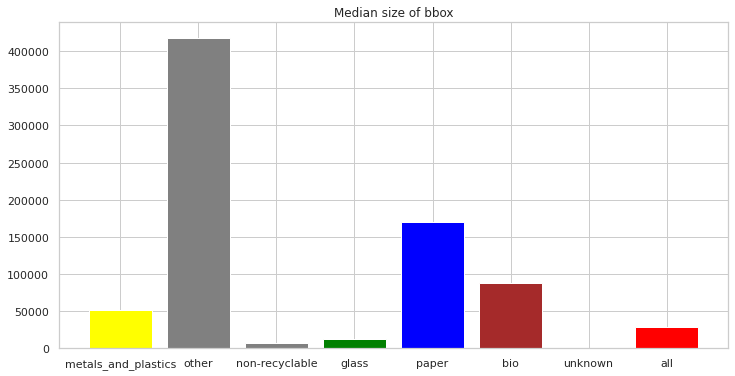

In [22]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0

# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = []
colors = colors_recykling.copy()
colors.append('red')
plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()

['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown', 'all']


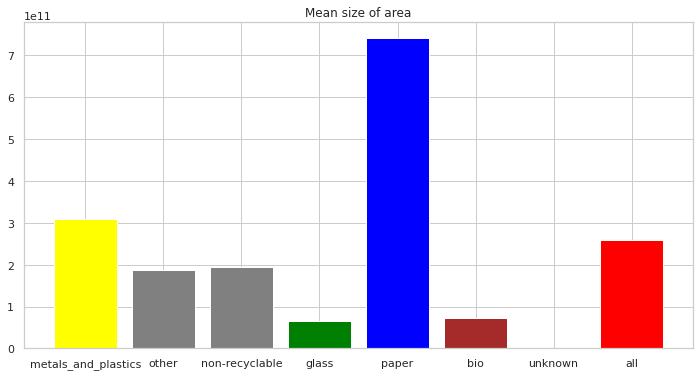

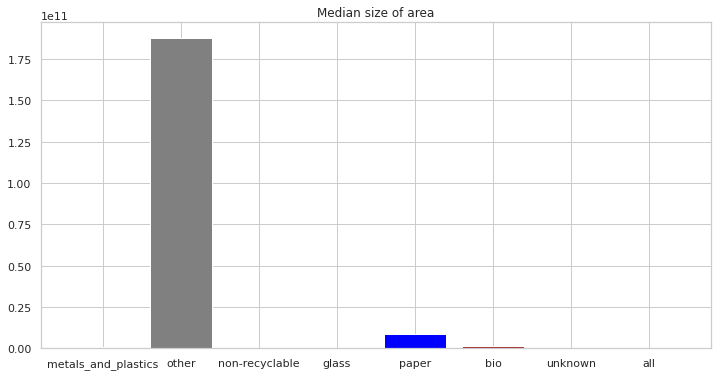

In [23]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

## Number of bboxes per image

In [24]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 3.1893333333333334

 metals_and_plastics
Maximum bboxes:  33
Mean number of bboxes:  2.0803782505910164
Median number of bboxes:  1.0

 other

 non-recyclable
Maximum bboxes:  25
Mean number of bboxes:  2.1226765799256504
Median number of bboxes:  1.0

 glass
Maximum bboxes:  2
Mean number of bboxes:  1.1
Median number of bboxes:  1.0

 paper
Maximum bboxes:  5
Mean number of bboxes:  1.5128205128205128
Median number of bboxes:  1.0

 bio

 unknown
Maximum bboxes:  9
Mean number of bboxes:  2.0638297872340425
Median number of bboxes:  1.0


## Number of images per image shape

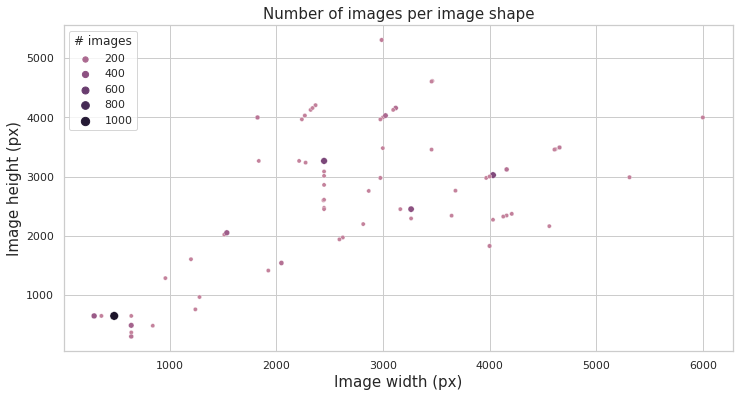

In [38]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)
for img in epinote_dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

## Placement of central point of the bbox in the image

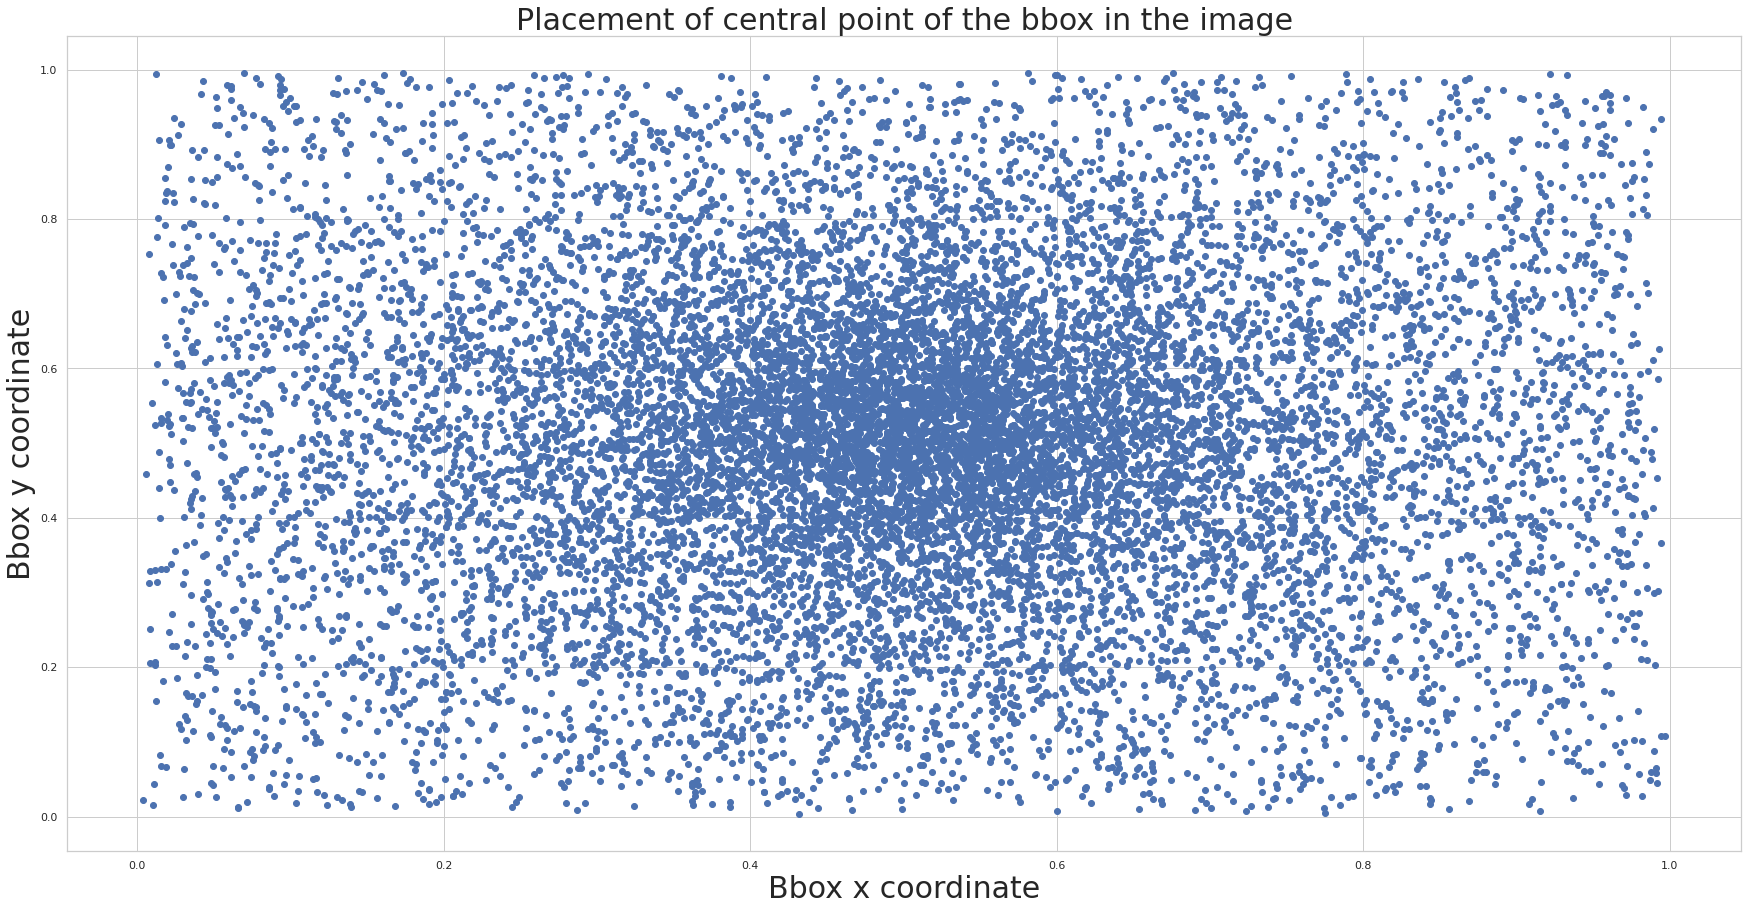

In [31]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
for i in range(0, len(epi_anns)):
    for j in range (0, len(epinote_dataset['images'])):
        if epinote_dataset['images'][j]['id'] == epi_anns[i]['image_id']:
            
            center_x.append((epi_anns[i]['bbox'][0]+epi_anns[i]['bbox'][2]/2)/epinote_dataset['images'][j]['width'])
            center_y.append((epi_anns[i]['bbox'][1]+epi_anns[i]['bbox'][3]/2)/epinote_dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

## Number of annotations per image

Mean number of annotations per image: 3.096228868660598


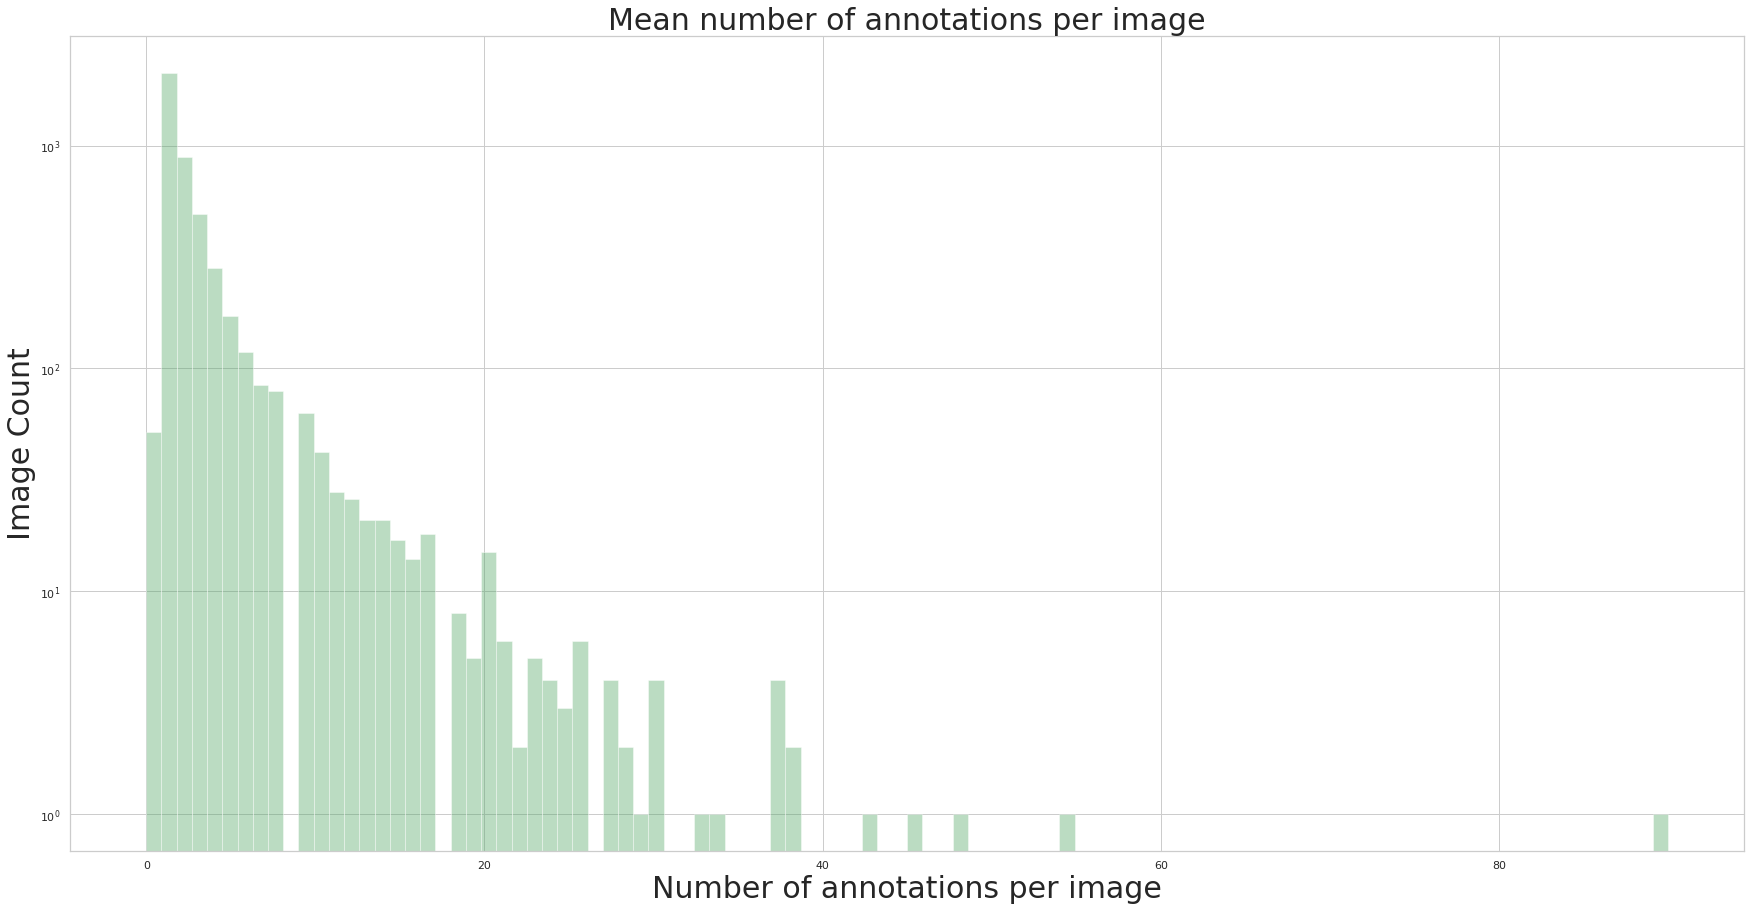

In [33]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))
for img in epinote_dataset['images']:
    annotations_per_image = []
    for i in range(0, len(epi_anns)):
        if img['id'] == epi_anns[i]['image_id']:
            annotations_per_image.append(epi_anns[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image)) 
plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

## Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
5763 small objects (area<32*32 px)
8224 medium objects (area<96*96 px)
9475 large objects (area>96*96 px)


/home/mferlin/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Number of bboxes smaller than 1024: 14058
Number of bboxes larger than 1024: 228
Number of missing annotations 2408


Text(0.5, 1.0, 'Bounding-boxes size')

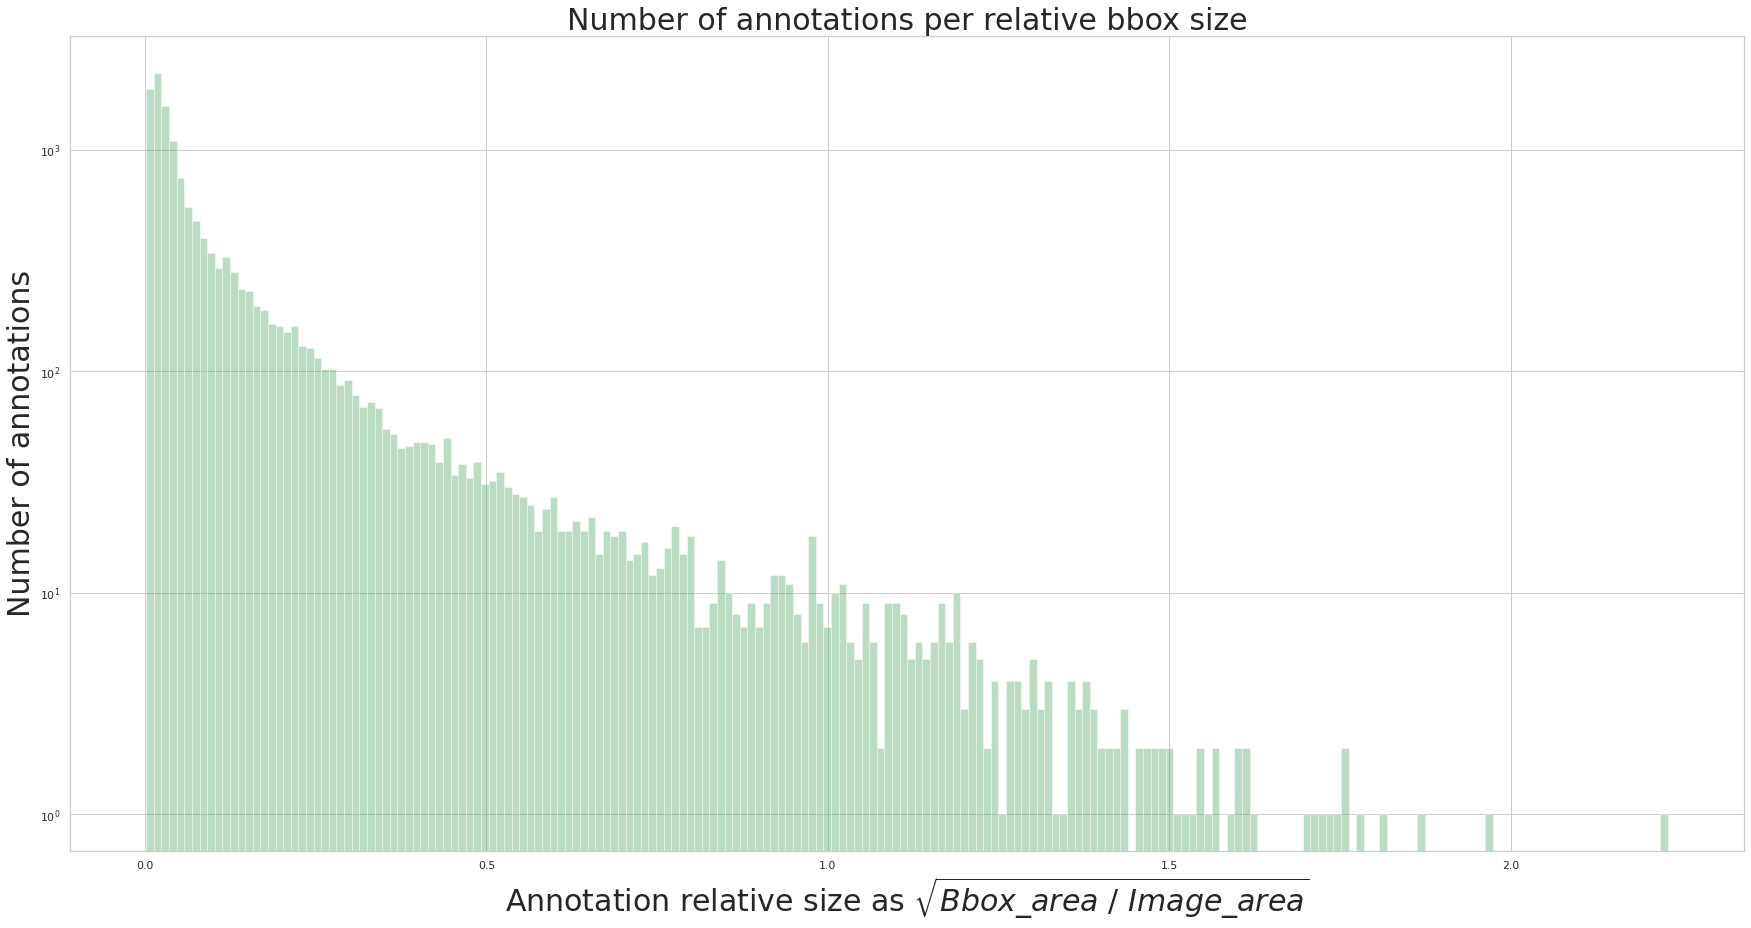

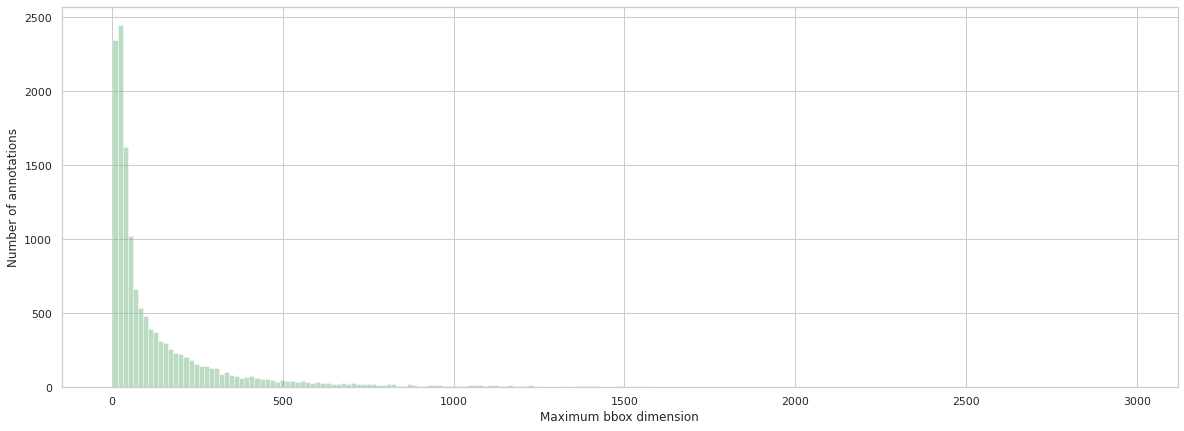

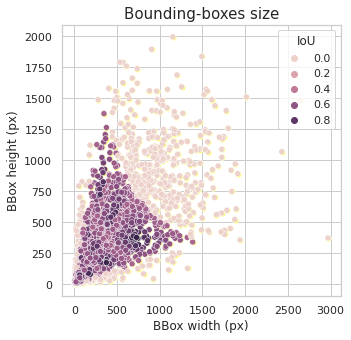

In [36]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
for ann in epi_anns:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)